In [1]:
import yfinance as yf

In [2]:
#constraints

budget = 20000
risk_tolerance = 0.5 # q 

In [3]:
#calculating the return
def daily_returns(yesterday, today):
    if yesterday == 0:
        return 0
    return (today - yesterday) / yesterday

def expected_return(days, list_of_returns):
    return sum(list_of_returns) / days

def variance_of_asset(list_of_returns, days):
    mean_return = expected_return(days, list_of_returns)
    return sum((r - mean_return) ** 2 for r in list_of_returns) / days

def covariance(asset1_returns, asset2_returns, days):
    mean_asset1 = expected_return(days, asset1_returns)
    mean_asset2 = expected_return(days, asset2_returns)
    return sum((asset1_returns[i] - mean_asset1) * (asset2_returns[i] - mean_asset2) for i in range(days)) / days

In [4]:
import pandas as pd

tickers = ['AAPL', 'IBM', 'NFLX', 'TSLA']
data = yf.download(tickers, start="2023-01-01", end="2025-01-01")

close_prices = data['Close']

#close_prices = close_prices.pct_change().dropna()

def compute_return_and_variance(ticker, close_prices):
    list_of_returns = []
    for i in range(1, len(close_prices[ticker])):
        daily_return = daily_returns(close_prices[ticker].iloc[i-1], close_prices[ticker].iloc[i])
        list_of_returns.append(daily_return)
    average_return = expected_return(len(list_of_returns), list_of_returns)
    variance = variance_of_asset(list_of_returns, len(list_of_returns))
    print(f"Average daily return for {ticker}: {average_return:.4f}")
    print(f"Variance of daily returns for {ticker}: {variance:.4f}")
    return average_return, variance

for ticker in tickers:
    compute_return_and_variance(ticker, close_prices)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed

Average daily return for AAPL: 0.0015
Variance of daily returns for AAPL: 0.0002
Average daily return for IBM: 0.0011
Variance of daily returns for IBM: 0.0002
Average daily return for NFLX: 0.0024
Variance of daily returns for NFLX: 0.0005
Average daily return for TSLA: 0.0033
Variance of daily returns for TSLA: 0.0013


another way of calculating returns

In [5]:
returns = close_prices.pct_change().dropna()
mean_returns = returns.mean()
for ticker in tickers:
    print(f"Average daily return for {ticker}: {mean_returns[ticker]:.4f}")
cov_matrix = returns.cov()
print("\nCovariance Matrix:")   
print(cov_matrix)

Average daily return for AAPL: 0.0015
Average daily return for IBM: 0.0011
Average daily return for NFLX: 0.0024
Average daily return for TSLA: 0.0033

Covariance Matrix:
Ticker      AAPL       IBM      NFLX      TSLA
Ticker                                        
AAPL    0.000181  0.000025  0.000103  0.000186
IBM     0.000025  0.000158  0.000040  0.000007
NFLX    0.000103  0.000040  0.000454  0.000191
TSLA    0.000186  0.000007  0.000191  0.001349


In [6]:
Sigma = cov_matrix.to_numpy()

QUBO (quadratic unconstrained binary optimization)

In [7]:
import numpy as np
last_day = close_prices.iloc[-1]
asset_prices = [(ticker, last_day[ticker]) for ticker in tickers]
print("\nAsset Prices on Last Day:")
for ticker, price in asset_prices:
    print(f"{ticker}: ${price:.2f}")

#calculate n_i max for each asset:
n_i_max_list = []
for ticker, price in asset_prices:
    n_i_max = budget // price
    n_i_max_list.append((ticker, n_i_max))
    print(f"Maximum number of shares for {ticker} with budget ${budget}: {n_i_max}")



Asset Prices on Last Day:
AAPL: $249.82
IBM: $216.93
NFLX: $891.32
TSLA: $403.84
Maximum number of shares for AAPL with budget $20000: 80.0
Maximum number of shares for IBM with budget $20000: 92.0
Maximum number of shares for NFLX with budget $20000: 22.0
Maximum number of shares for TSLA with budget $20000: 49.0


In [8]:
d_i_list = []
for ticker, n_i_max in n_i_max_list:
    if n_i_max > 0:
        d_i = int(np.floor(np.log2(n_i_max)))
    else:
        d_i = 0
    d_i_list.append((ticker, d_i))
    print(f"Value of d_i for {ticker}: {d_i}")


Value of d_i for AAPL: 6
Value of d_i for IBM: 6
Value of d_i for NFLX: 4
Value of d_i for TSLA: 5


In [9]:
d_values = [d_i for _, d_i in d_i_list]
num_assets = len(d_values)
total_bits = sum(d+ 1 for d in d_values)
print(f"\nTotal number of bits required for all assets: {total_bits}")


Total number of bits required for all assets: 25


constructing the encoding matrix $C$

In [10]:
C = np.zeros((num_assets, total_bits))

col = 0 

for i, d in enumerate(d_values):
    for j in range(d+1):
        C[i, col] = 2 ** j
        col += 1


Calculating 
$$
P'= P/B \\
\mu' = P' \circ \mu \\
\Sigma' = (P' \circ \Sigma)^T \circ P'\\
\mu^{\prime\prime} = C^T \mu' \\
\Sigma'' = C^T \Sigma'C \\
P'' = C^T P'
$$

In [11]:
# List P of current prices of assets 
P = np.array([price for _, price in asset_prices])
P_prime = P / budget
P_double_prime = C.T @ P_prime


mu = np.array([mean_returns[ticker] for ticker in tickers])
mu_prime = P_prime * mu 

mu_prime_series = pd.Series(mu_prime, index=tickers)


print("\nScaled expected return vector µ′:")
print(mu_prime_series)




Scaled expected return vector µ′:
AAPL    0.000019
IBM     0.000012
NFLX    0.000108
TSLA    0.000067
dtype: float64


In [12]:
P_prime_sigma = P_prime * Sigma
Sigma_prime = P_prime_sigma.T * P_prime 

mu_double_prime = C.T @ mu_prime

Sigma_double_prime = C.T @ Sigma_prime @ C


Constructing the Hamiltonian

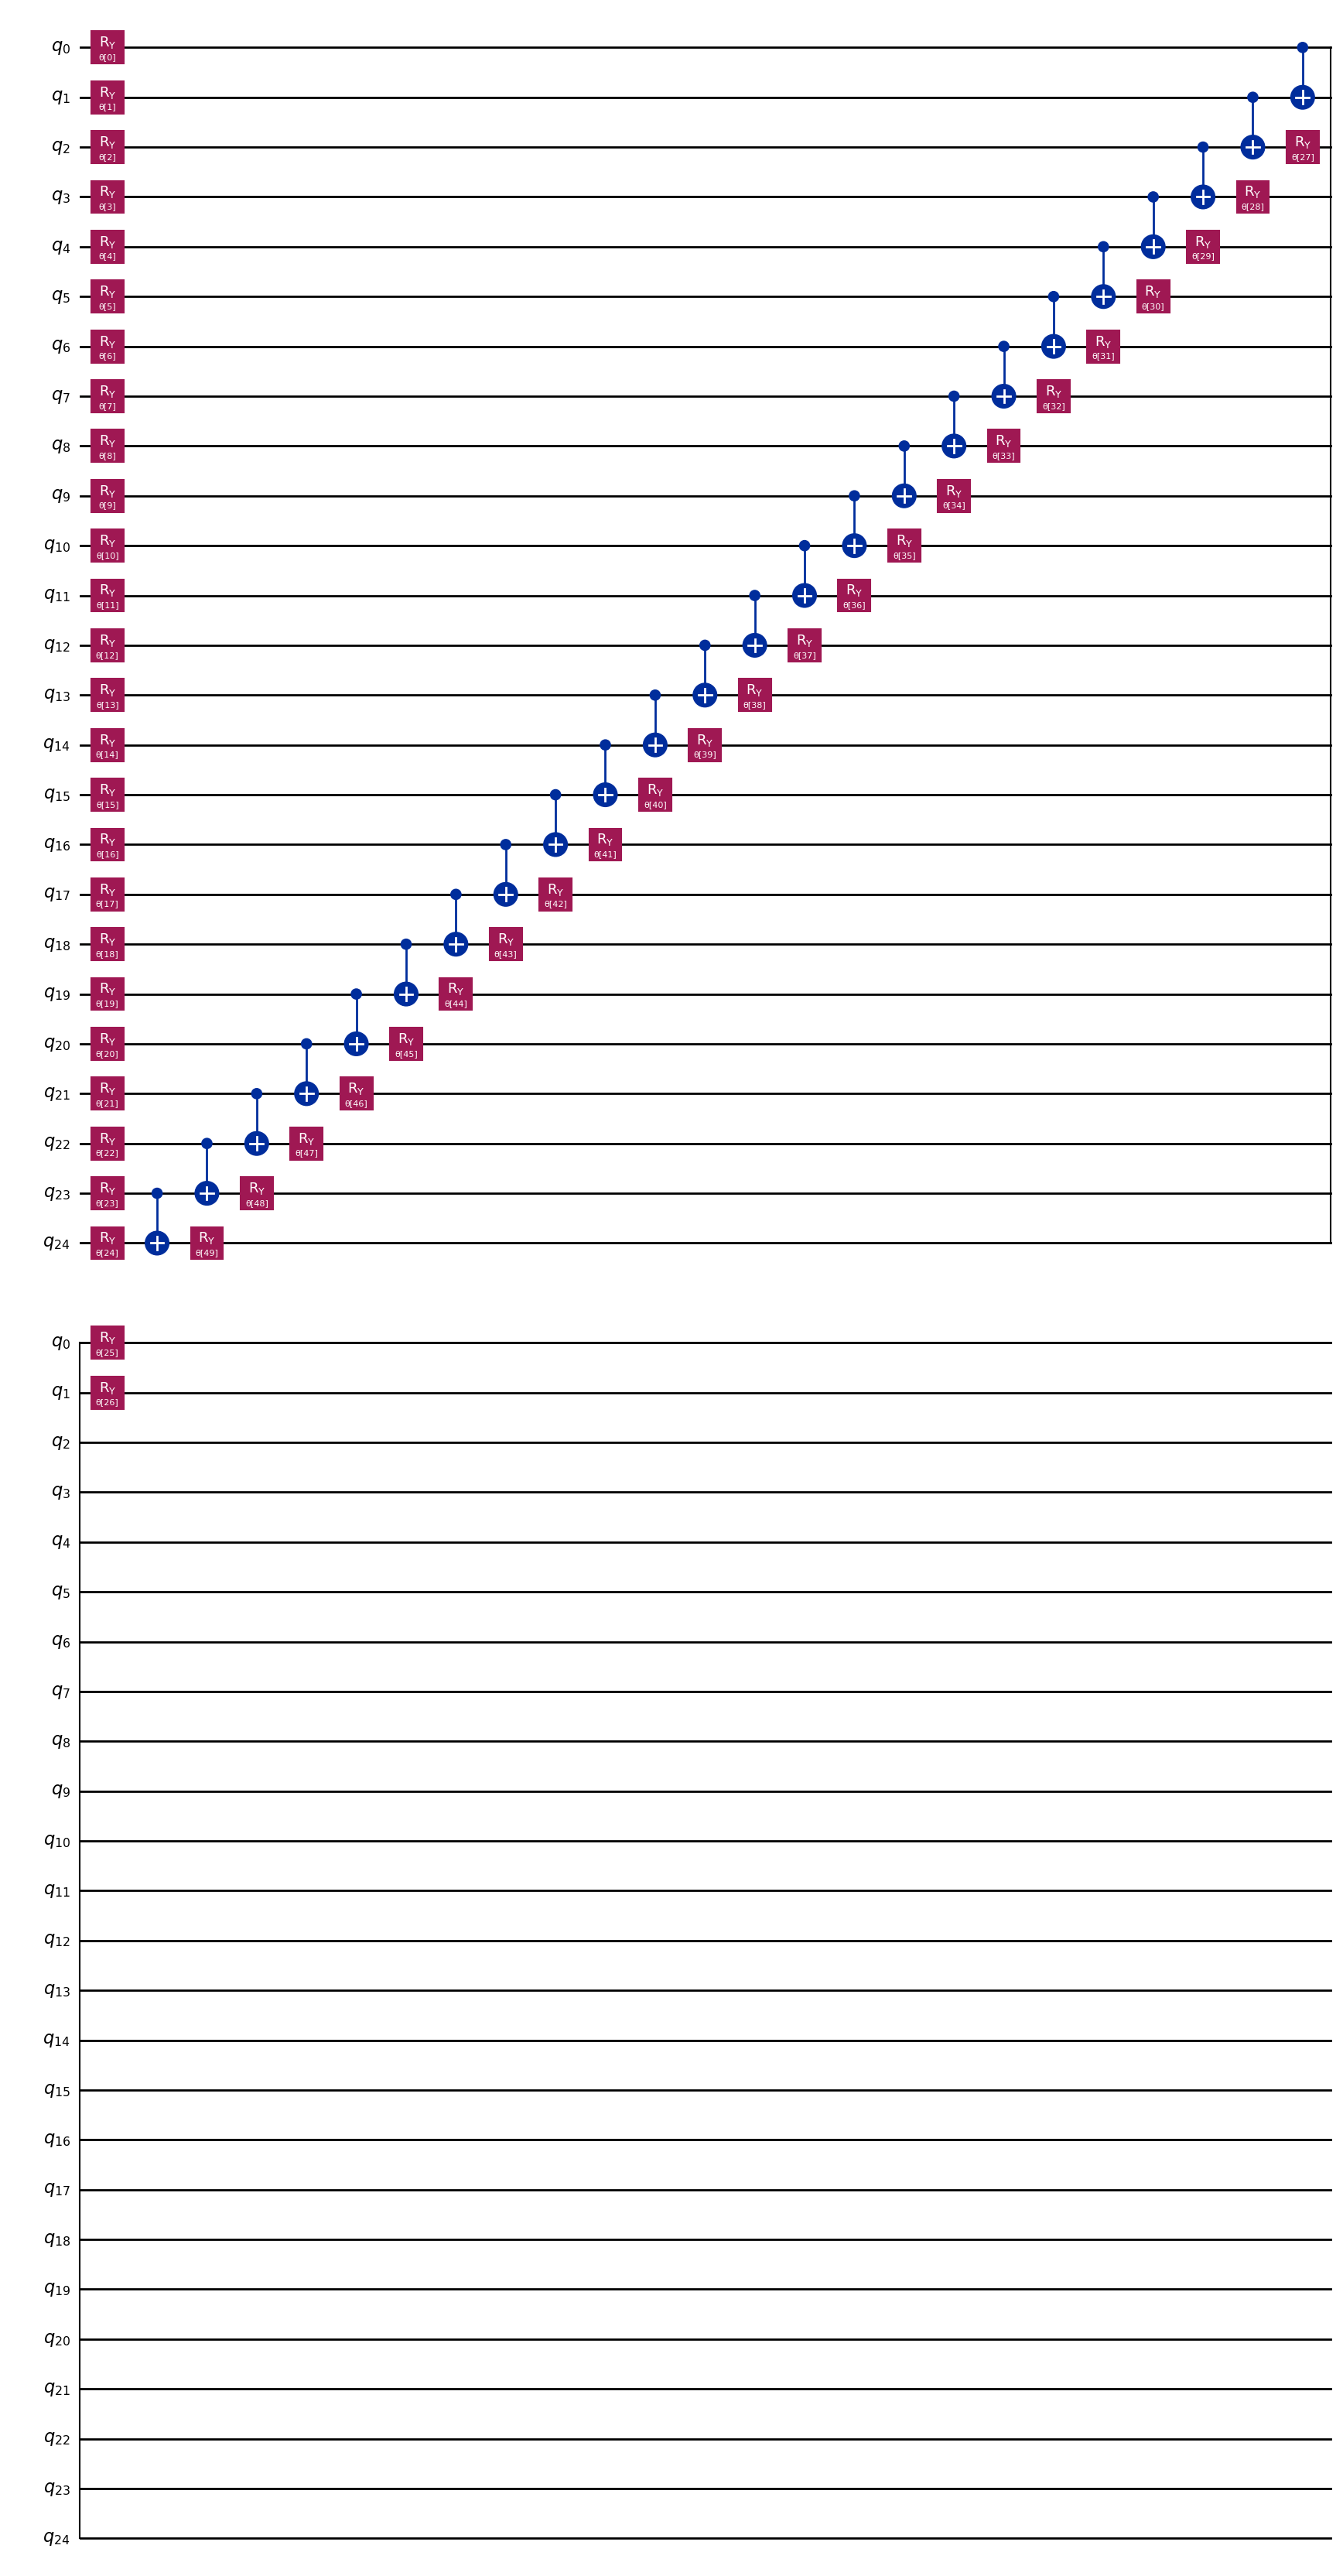

In [13]:
from qiskit.quantum_info import SparsePauliOp, Pauli
#Constraints
pi = 0.5 * P_double_prime
beta = 1 - np.sum(pi)
n = len(P_double_prime) #total number of binary variables
penalty = 10
#QUBO terms
h_q = mu_double_prime - 2 * penalty * P_double_prime #linear term
Q_q = -risk_tolerance * Sigma_double_prime + penalty * np.outer(P_double_prime, P_double_prime) #quadratic term


h_ising = np.zeros(n)
J_ising = np.zeros((n, n))
for i in range(n):
    h_ising[i] = 0.5 * h_q[i] + 0.5 * np.sum(Q_q[i])
    for j in range(i + 1, n):
        J_ising[i, j] = 0.25 * Q_q[i, j]

for i in range(n):
    h_ising[i] += -2 * penalty * beta * pi[i]
    for j in range(i + 1, n):
        J_ising[i, j] += 2 * penalty * pi[i] * pi[j]


# Build dictionary of Pauli terms
pauli_dict = {}

# Z_i terms
for i in range(n):
    label = ['I'] * n
    label[n - i - 1] = 'Z'  # note Qiskit uses reversed qubit order
    pauli_str = ''.join(label)
    pauli_dict[pauli_str] = pauli_dict.get(pauli_str, 0) + h_ising[i]

# Z_i Z_j terms
for i in range(n):
    for j in range(i + 1, n):
        if J_ising[i, j] != 0:
            label = ['I'] * n
            label[n - i - 1] = 'Z'
            label[n - j - 1] = 'Z'
            pauli_str = ''.join(label)
            pauli_dict[pauli_str] = pauli_dict.get(pauli_str, 0) + J_ising[i, j]

# Create SparsePauliOp
pauli_terms = list(pauli_dict.items())
hamiltonian = SparsePauliOp.from_list(pauli_terms)

from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorEstimator, Sampler
estimator = StatevectorEstimator()
ansatz = RealAmplitudes(hamiltonian.num_qubits, reps=1)
optimizer = COBYLA()
ansatz.decompose().draw('mpl')





In [14]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "parameters": [],
}

def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = parameters
    cost_history_dict["cost_history"].append(cost)
    cost_history_dict["parameters"].append(parameters)
    return cost

In [ ]:
from scipy.optimize import minimize
import numpy as np
from qiskit_aer import Aer
initial_params = np.random.uniform(low= -np.pi, high=np.pi, size=ansatz.num_parameters)
result = minimize(cost_func_vqe, initial_params, args=(ansatz, hamiltonian, estimator), method="COBYLA",options={'maxiter': 12000})
print(result)



capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [ ]:
from qiskit.quantum_info import Statevector

# Assign optimal parameters to ansatz
final_circuit = ansatz.bind_parameters(result.x)

final_circuit.measure_all()
simluator = Aer.get_backend('qasm_simulator')

job_state = simluator.run(final_circuit, shots=1000)

result = job_state.result()

counts = result.get_counts(final_circuit)

bitstring = max(counts, key=counts.get)
bitstring = bitstring[::-1]  # reverse Qiskit endianness

print("Most likely bitstring:", bitstring)

# Convert to vector
b = np.array([int(bit) for bit in bitstring])
n = C @ b
print("\nOptimal number of shares to buy for each asset:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {int(n[i])} shares")